In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'DUNI.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-12-31,833,-498,335,91,205,743,503,1563,1463,...,341,0,818,1731,11,2135,262,-38,47,2015-02-09
1,2015-03-31,985,-698,287,70,175,710,536,1530,1462,...,341,0,706,1570,17,2003,75,-19,47,2015-04-25
2,2015-06-30,1002,-718,284,68,185,686,531,1495,1459,...,325,0,0,833,838,2055,133,-33,47,2015-07-17
3,2015-09-30,1043,-731,312,99,175,727,571,1583,1461,...,311,0,0,897,793,2057,117,-54,47,2015-10-25
4,2015-12-31,1170,-812,358,109,203,660,500,1494,1455,...,352,0,0,920,553,1833,298,-58,47,2016-02-09


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-12-31,2024-02-09,47,1971,-1441,530,83,488,1125,1251,...,230,6913,719,0,342,2046,610,3491,460,-59
37,2024-03-31,2024-04-22,47,1736,-1300,435,83,395,1137,1430,...,298,7302,615,0,354,1949,833,3073,-183,-26
38,2024-06-30,2024-07-08,47,1875,-1423,453,84,275,1188,1461,...,279,7319,649,0,636,2362,568,3215,95,-41
39,2024-09-30,2024-10-21,47,1910,-1584,326,3,335,1176,1464,...,345,7580,676,0,633,2591,519,3478,219,-56
40,2024-12-31,2025-02-10,47,2057,-1540,517,107,323,1118,1476,...,311,7567,827,0,414,2204,695,3359,306,-93


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-09,47,1971,-1441,530,83,488,1125,1251,...,6913,719,0,342,2046,610,3491,460,-59,10.657495
37,2024-03-31,2024-04-22,47,1736,-1300,435,83,395,1137,1430,...,7302,615,0,354,1949,833,3073,-183,-26,10.376655
38,2024-06-30,2024-07-08,47,1875,-1423,453,84,275,1188,1461,...,7319,649,0,636,2362,568,3215,95,-41,10.684878
39,2024-09-30,2024-10-21,47,1910,-1584,326,3,335,1176,1464,...,7580,676,0,633,2591,519,3478,219,-56,10.423824
40,2024-12-31,2025-02-10,47,2057,-1540,517,107,323,1118,1476,...,7567,827,0,414,2204,695,3359,306,-93,10.770364


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-12-31,2024-02-09,47,1971,-1441,530,83,488,1125,1251,...,6913,719,0,342,2046,610,3491,460,-59,10.657495
37,2024-03-31,2024-04-22,47,1736,-1300,435,83,395,1137,1430,...,7302,615,0,354,1949,833,3073,-183,-26,10.376655
38,2024-06-30,2024-07-08,47,1875,-1423,453,84,275,1188,1461,...,7319,649,0,636,2362,568,3215,95,-41,10.684878
39,2024-09-30,2024-10-21,47,1910,-1584,326,3,335,1176,1464,...,7580,676,0,633,2591,519,3478,219,-56,10.423824
40,2024-12-31,2025-02-10,47,2057,-1540,517,107,323,1118,1476,...,7567,827,0,414,2204,695,3359,306,-93,10.770364


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2015-02-09,90.690788,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.506701,0.493299,0.0,0.0,0.0,0.0,0.402161,0.109244,0.0,0.0
1,2015-02-16,86.165298,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.506701,0.493299,0.0,0.0,0.0,0.0,0.402161,0.109244,0.0,0.0
2,2015-02-23,89.423653,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.506701,0.493299,0.0,0.0,0.0,0.0,0.402161,0.109244,0.0,0.0
3,2015-03-02,87.070404,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.506701,0.493299,0.0,0.0,0.0,0.0,0.402161,0.109244,0.0,0.0
4,2015-03-09,88.337547,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.506701,0.493299,0.0,0.0,0.0,0.0,0.402161,0.109244,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2015-02-09,90.690788,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.0,0.402161,0.109244,0.0,0.0,inf,1.943669,inf,inf,inf
1,2015-02-16,86.165298,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.0,0.402161,0.109244,0.0,0.0,inf,1.846680,inf,inf,inf
2,2015-02-23,89.423653,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.0,0.402161,0.109244,0.0,0.0,inf,1.916512,inf,inf,inf
3,2015-03-02,87.070404,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.0,0.402161,0.109244,0.0,0.0,inf,1.866078,inf,inf,inf
4,2015-03-09,88.337547,2014-12-31,833.0,0.0,46.659574,47.0,0.0,0.0,205.0,...,0.0,0.402161,0.109244,0.0,0.0,inf,1.893235,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

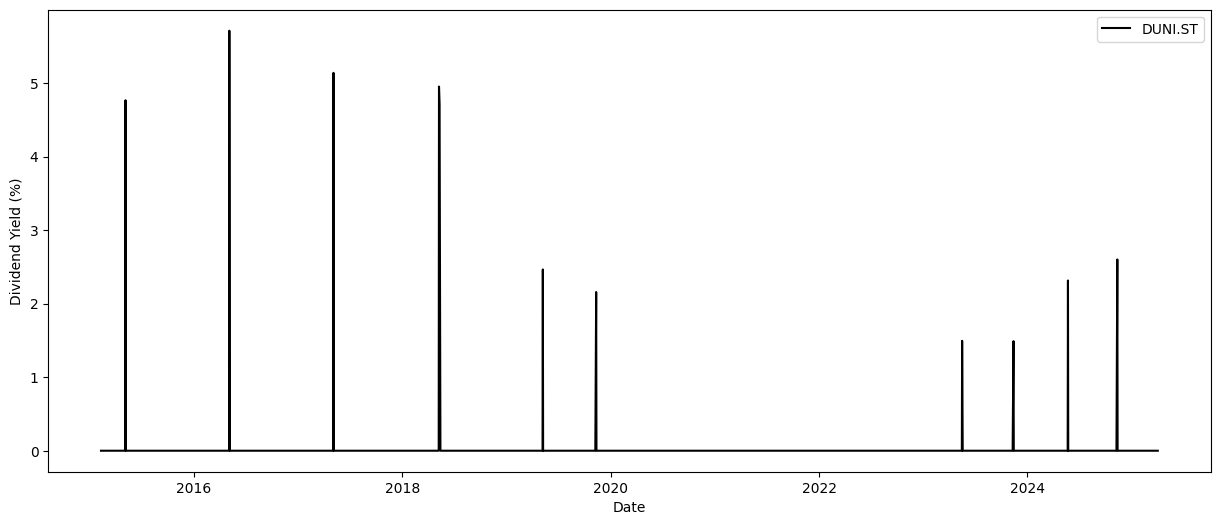

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.192289
share_price      1.000000
Name: share_price, dtype: float64


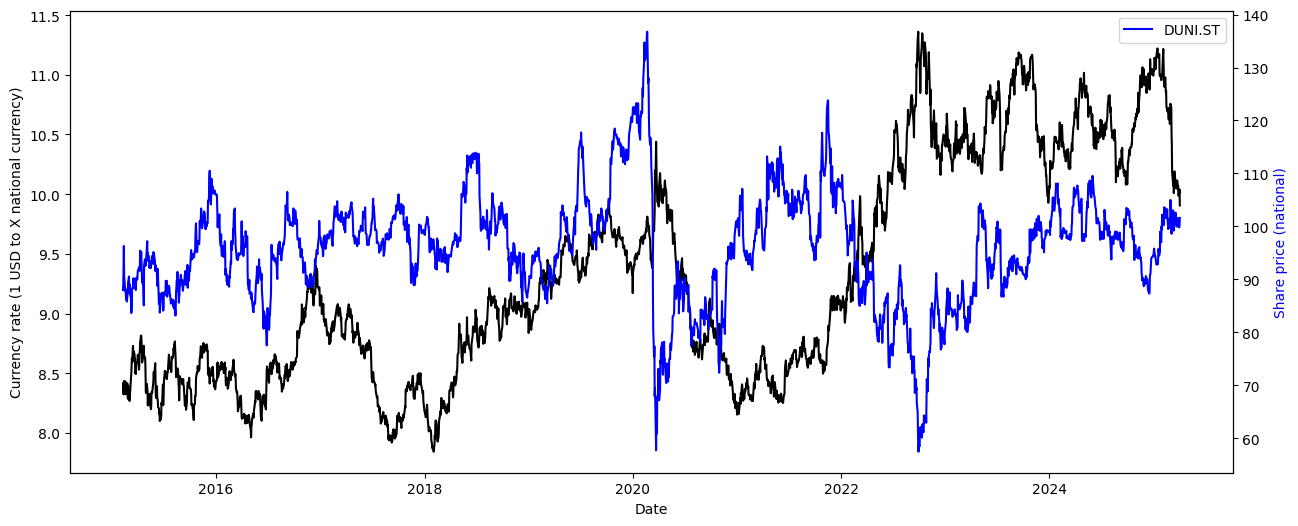

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

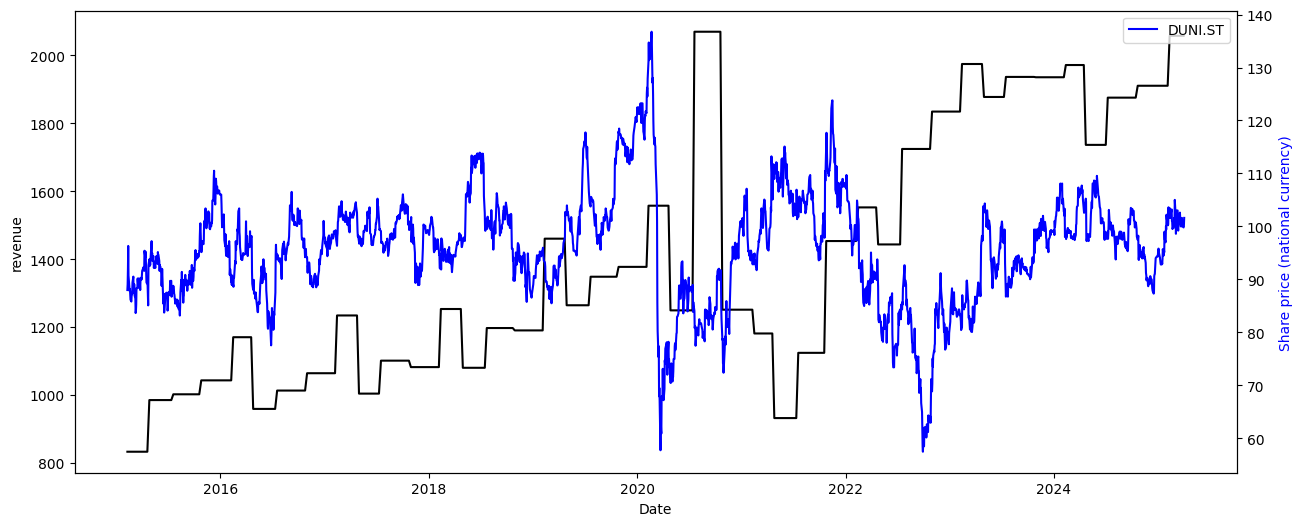

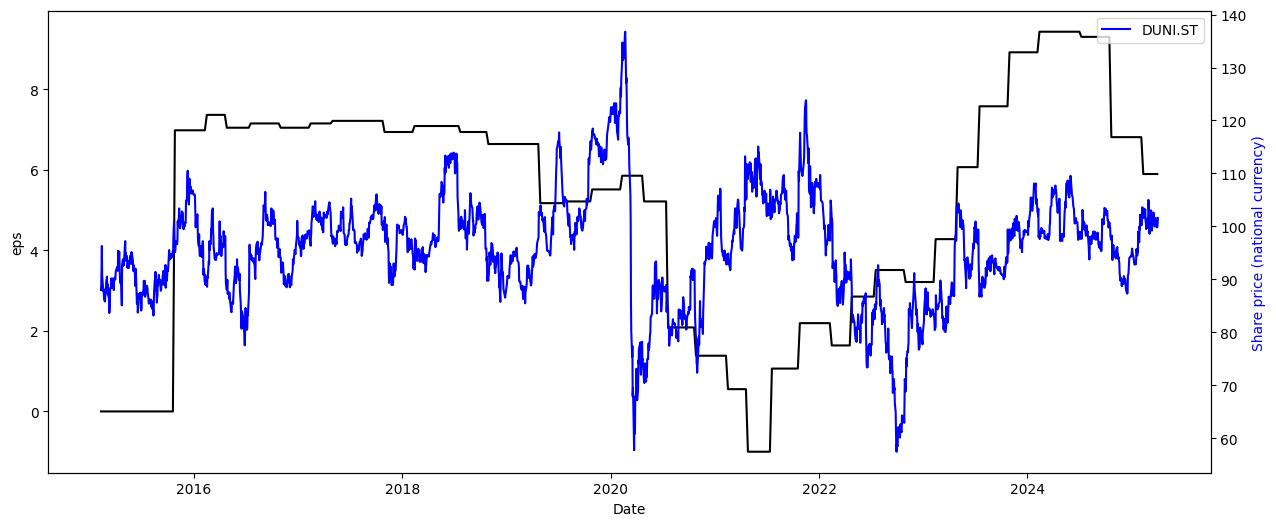

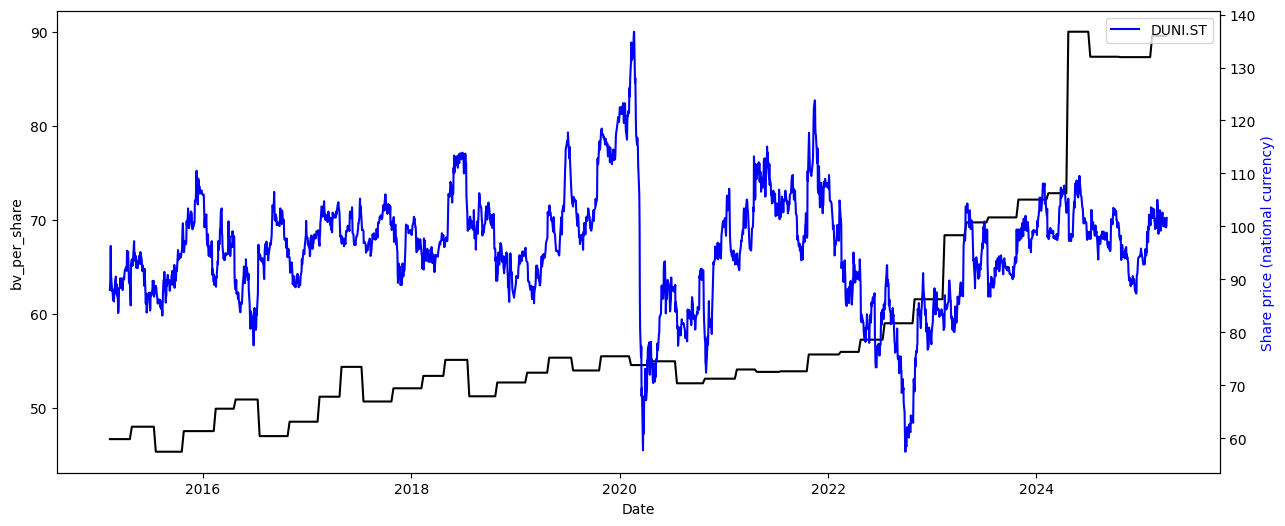

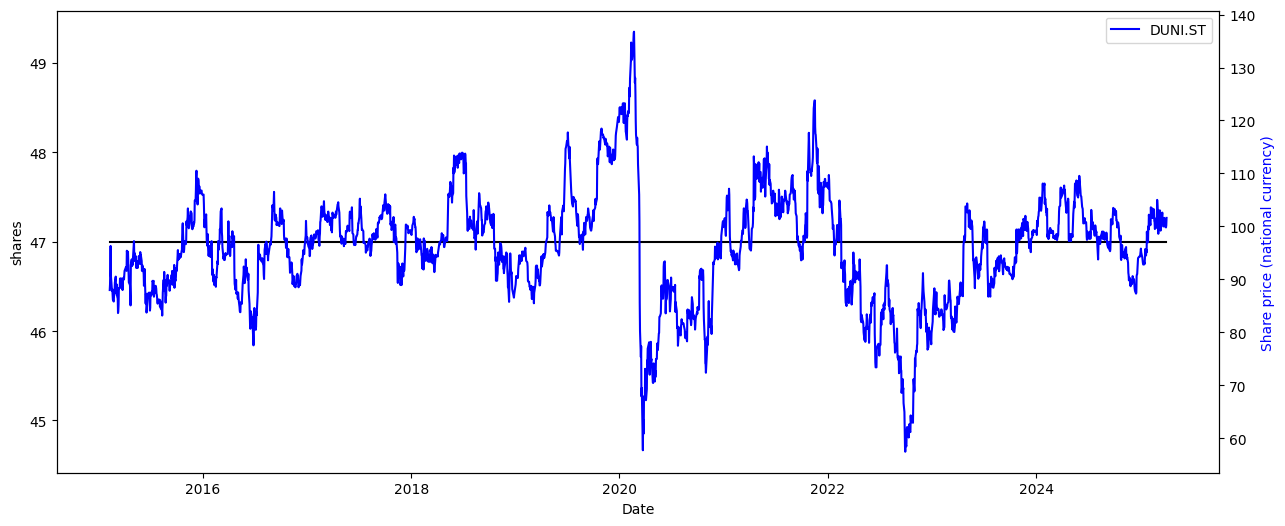

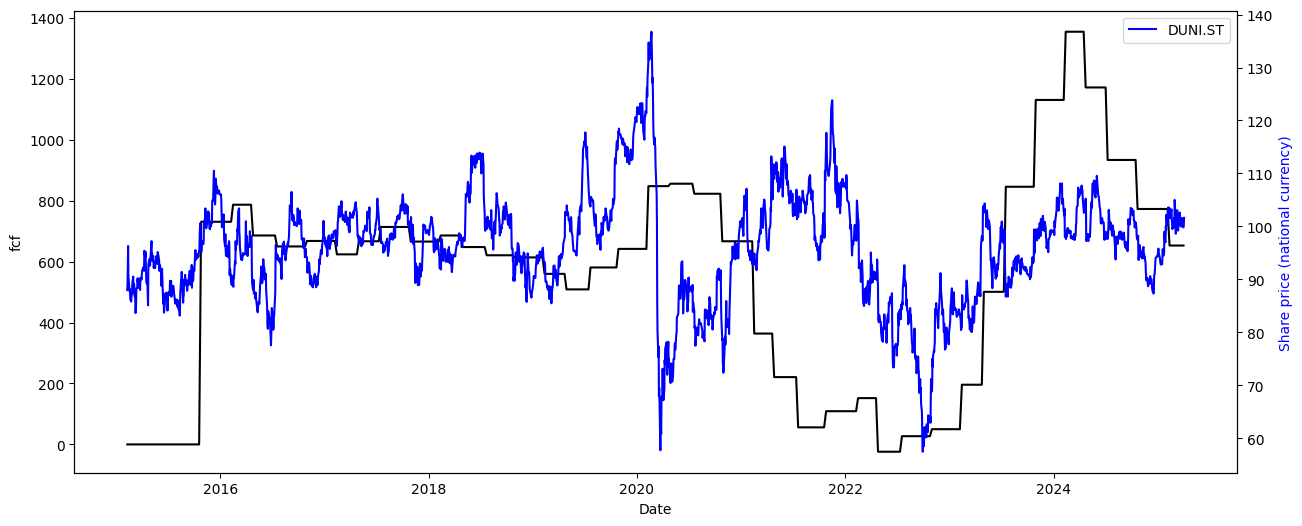

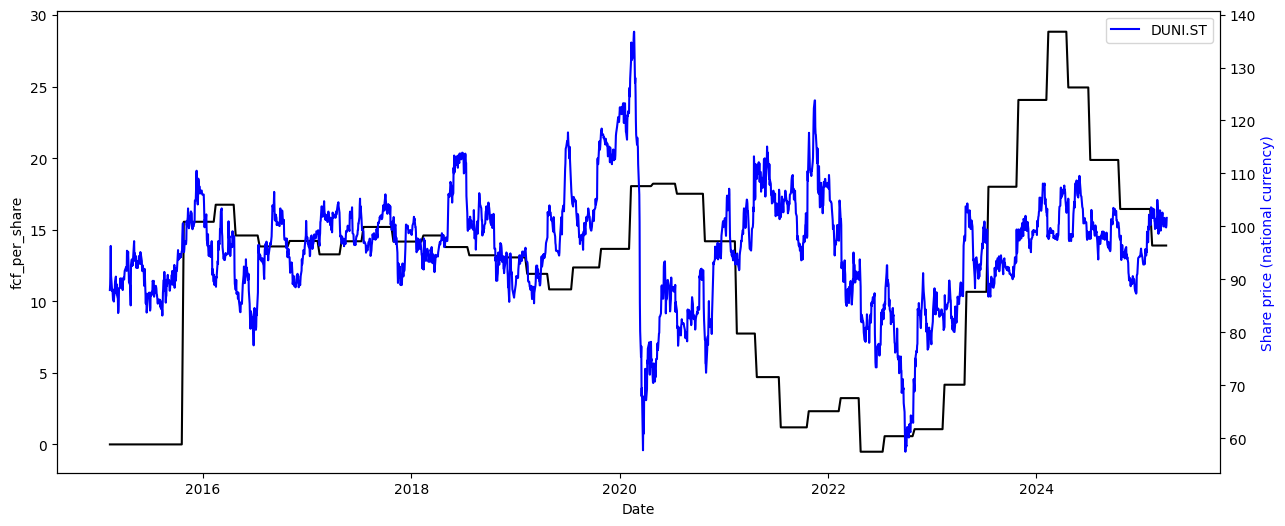

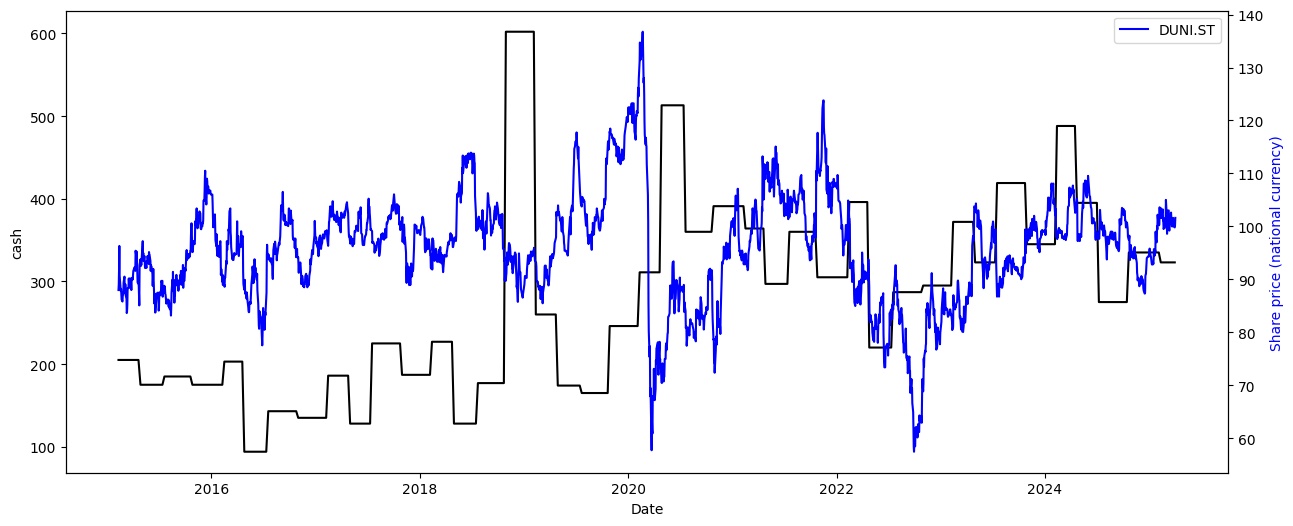

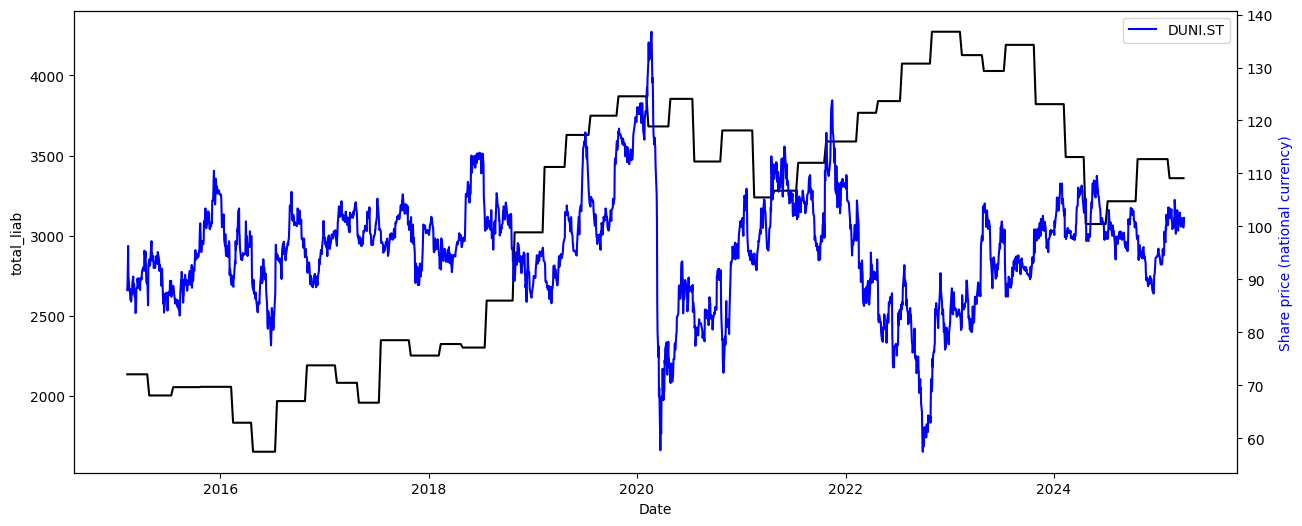

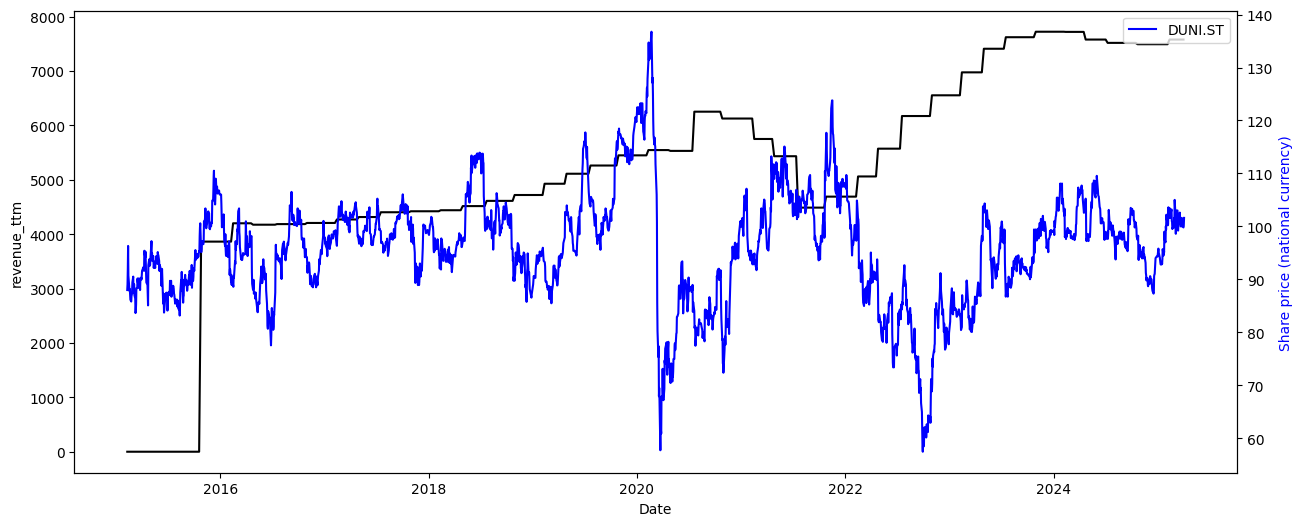

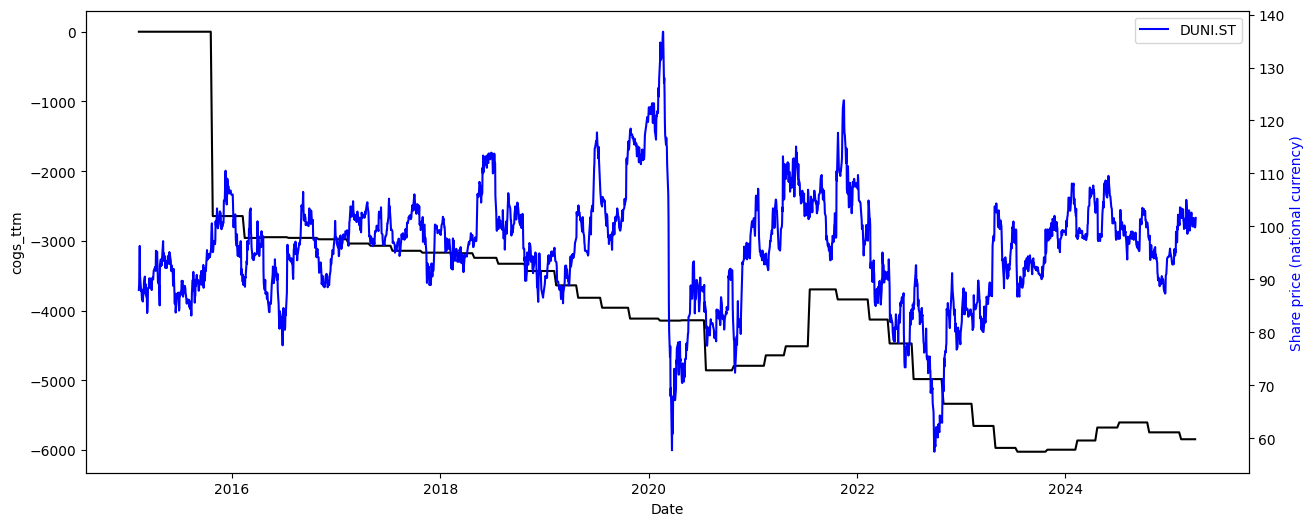

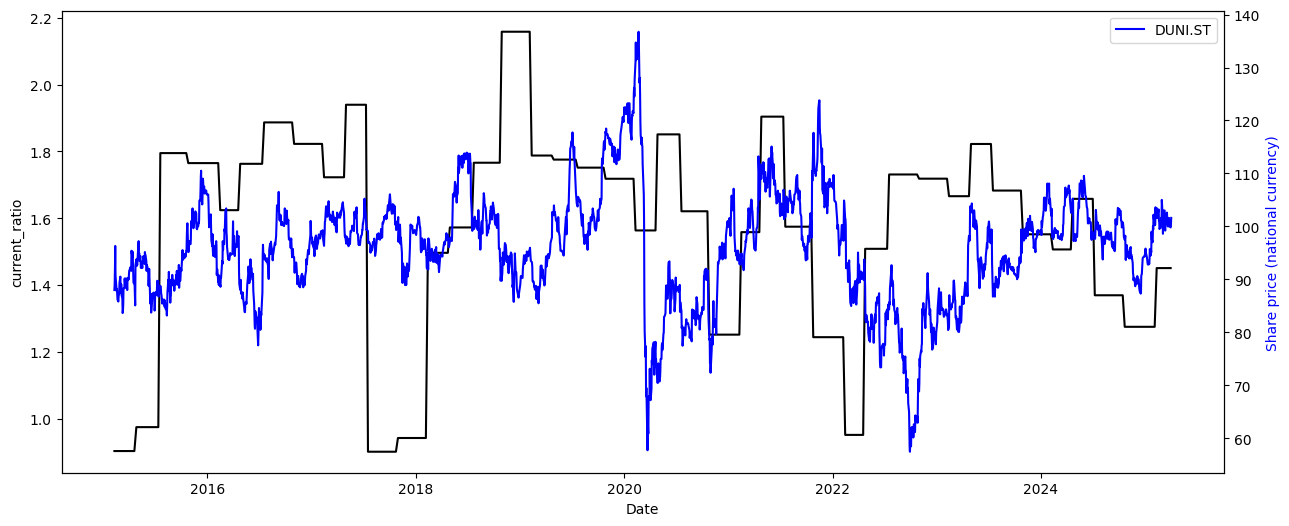

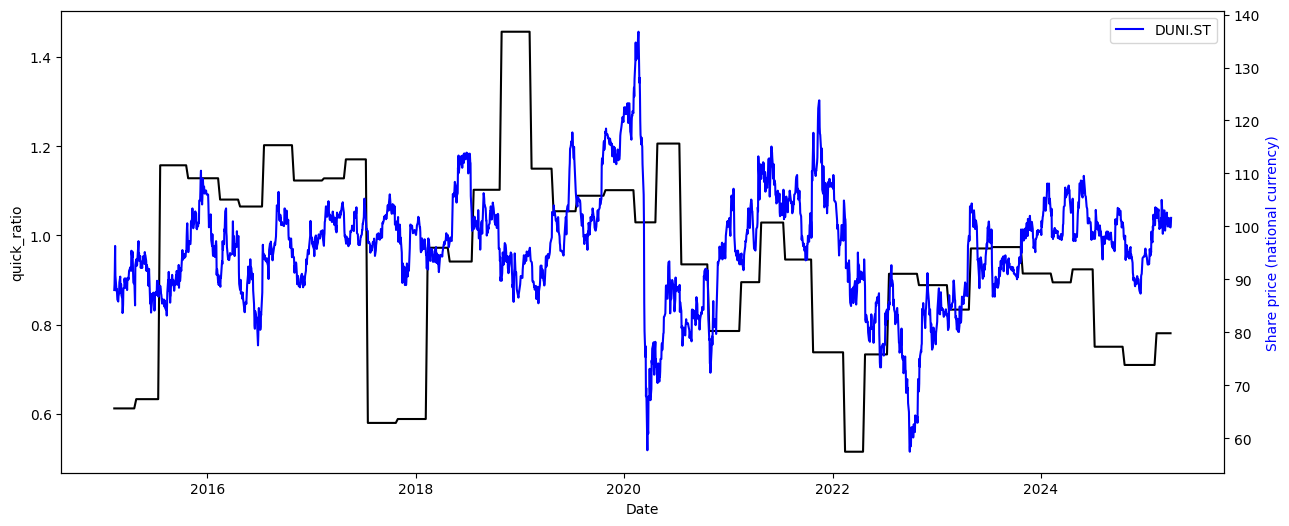

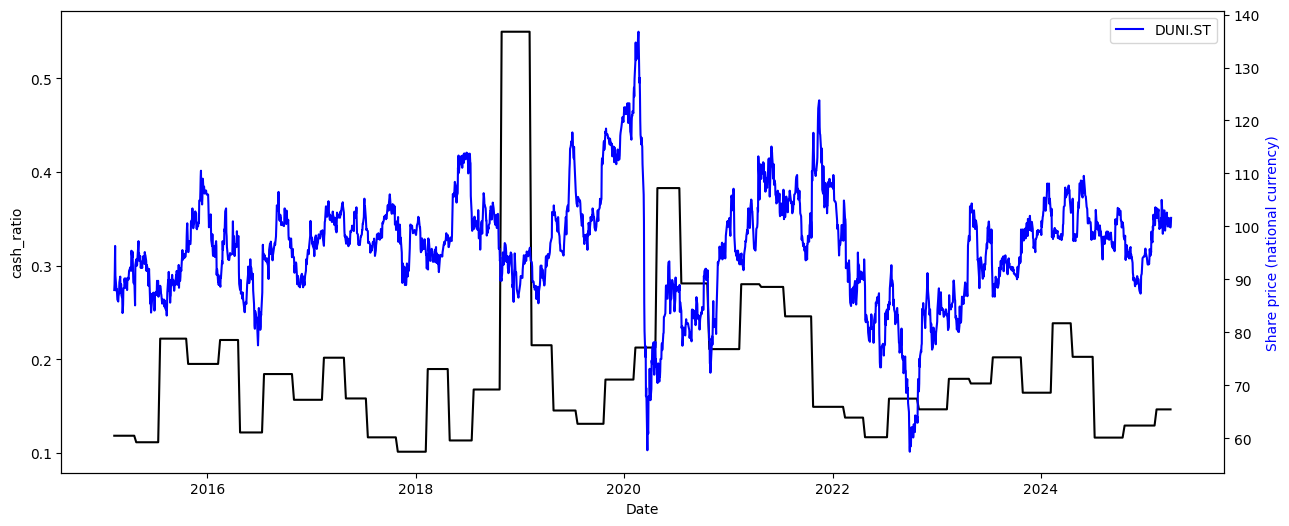

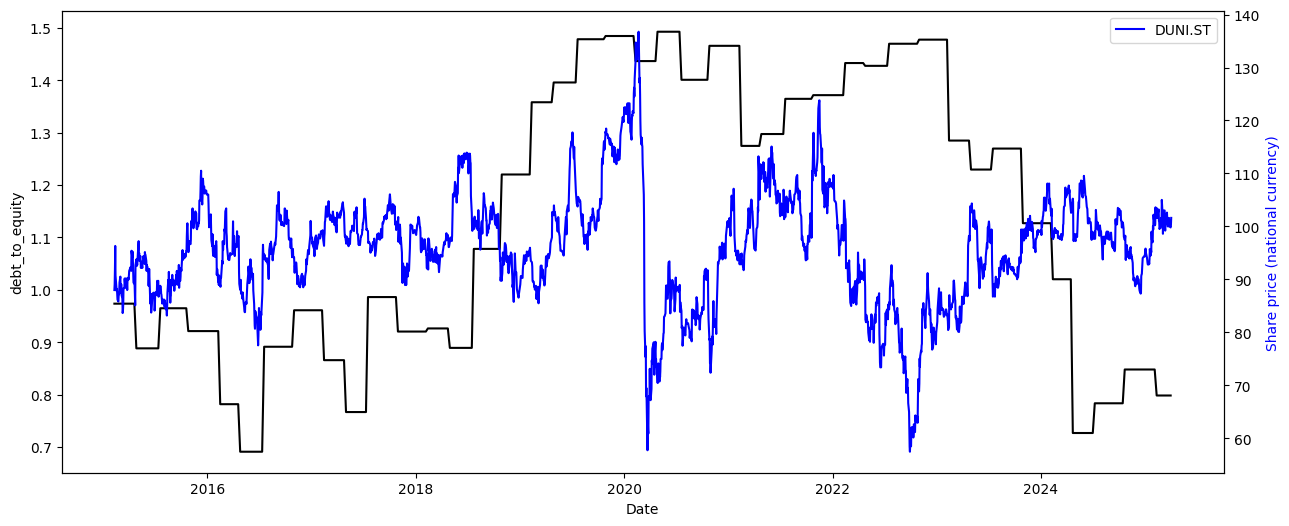

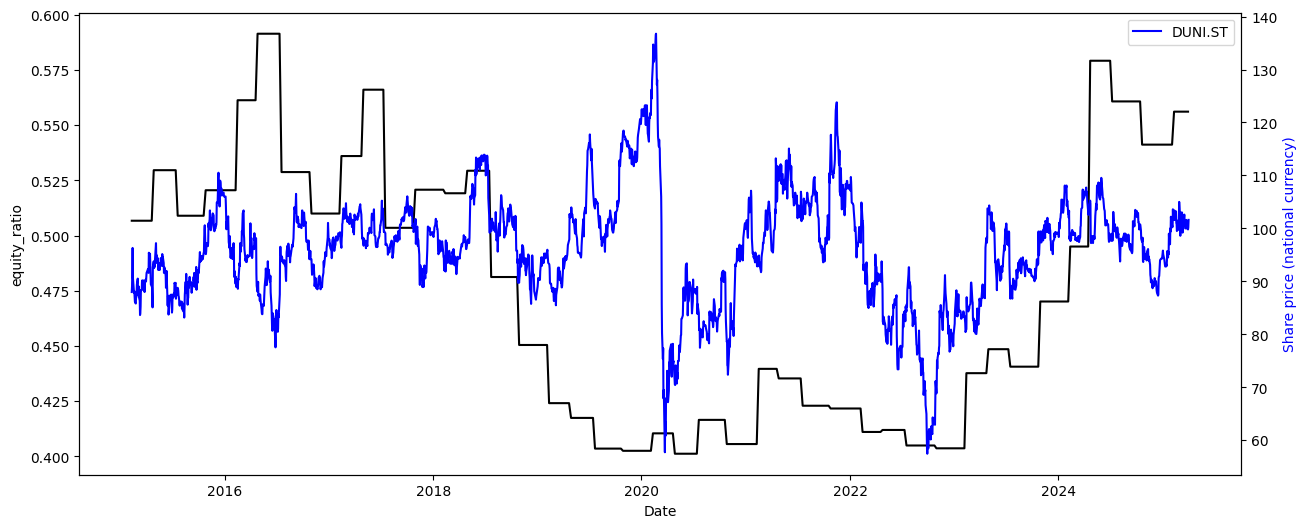

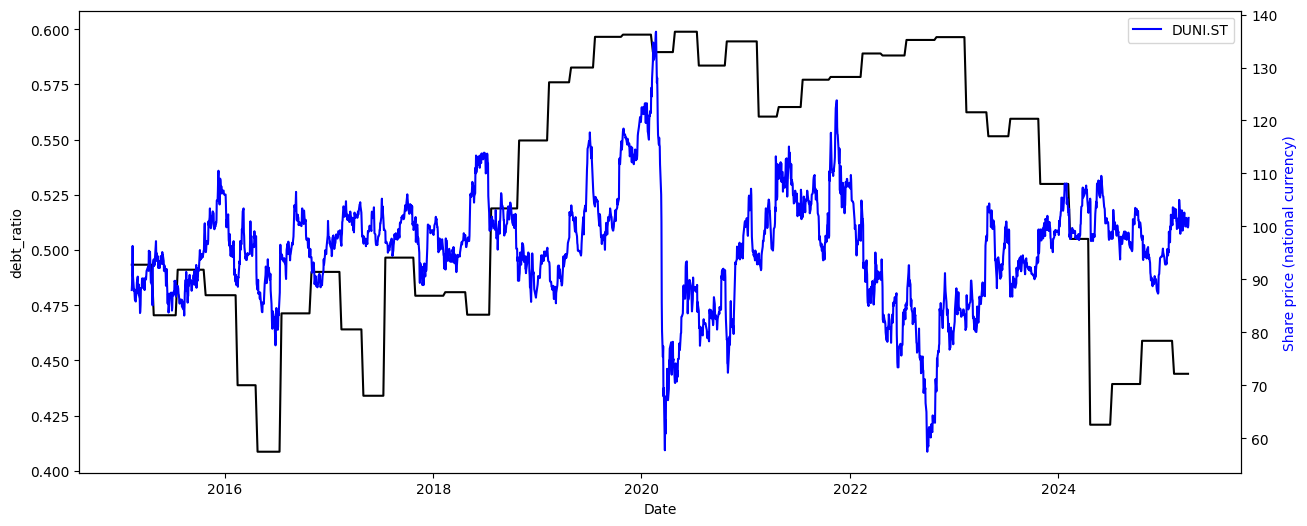

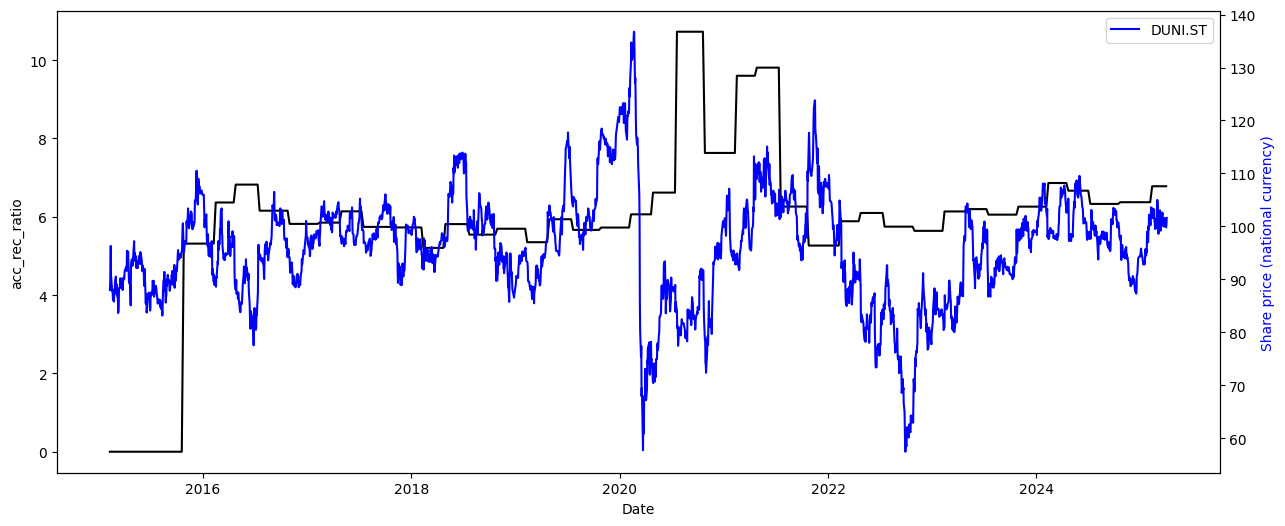

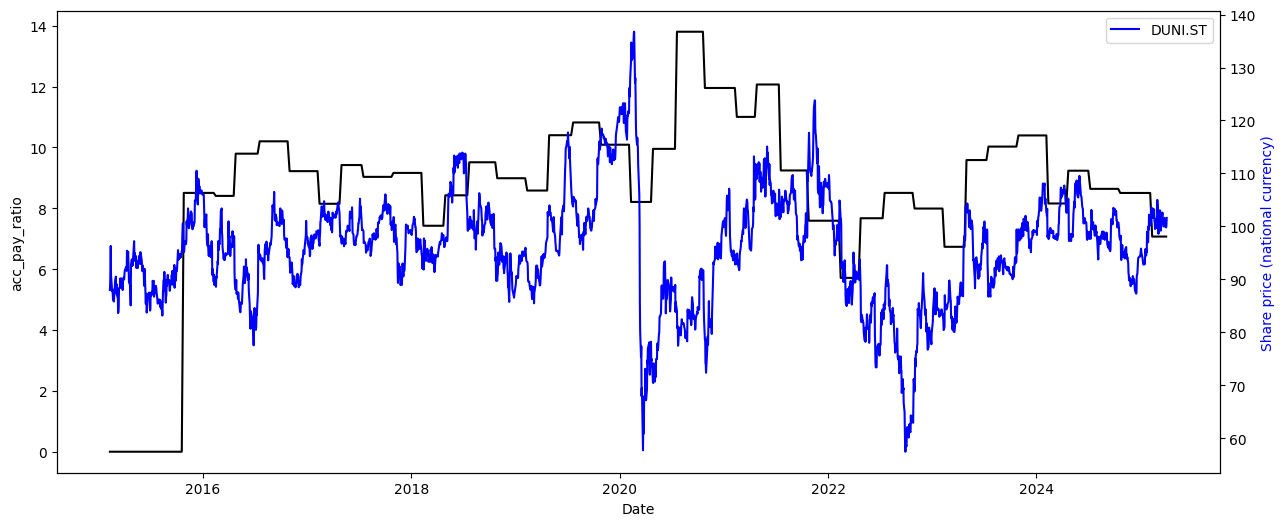

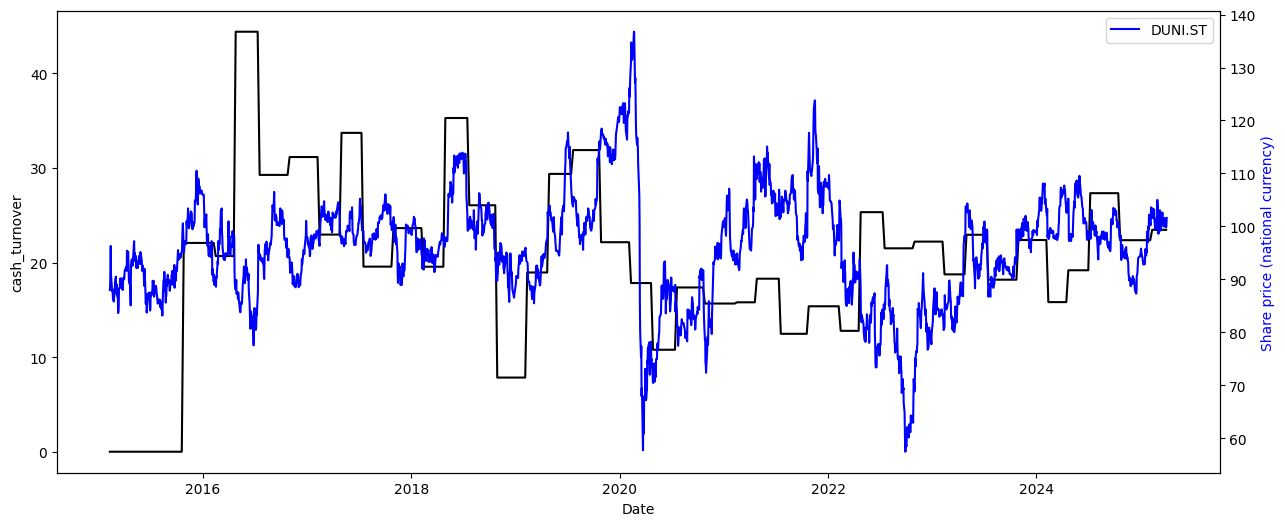

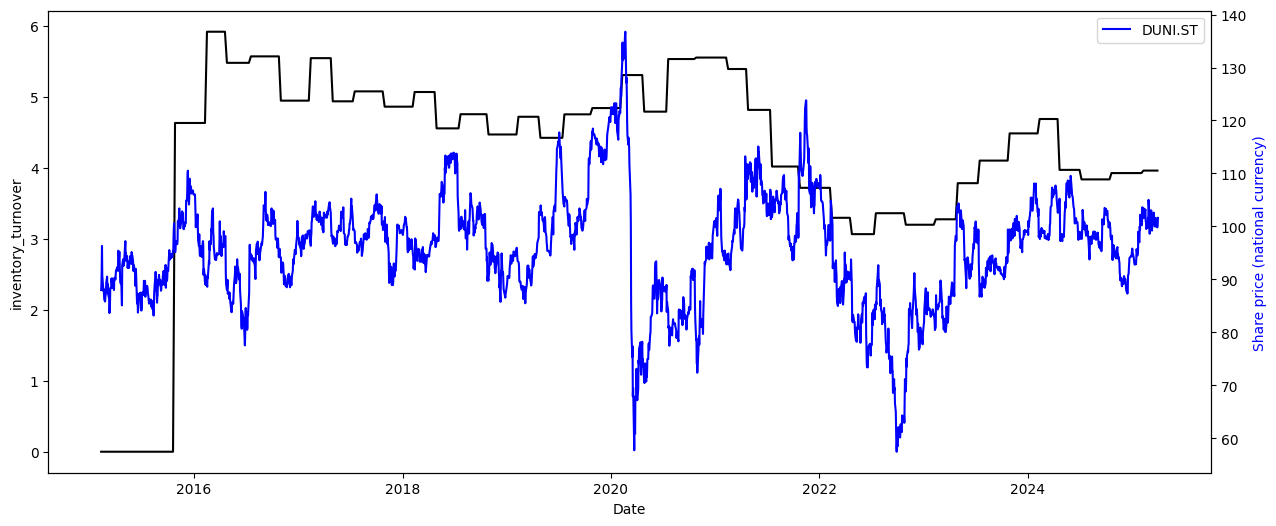

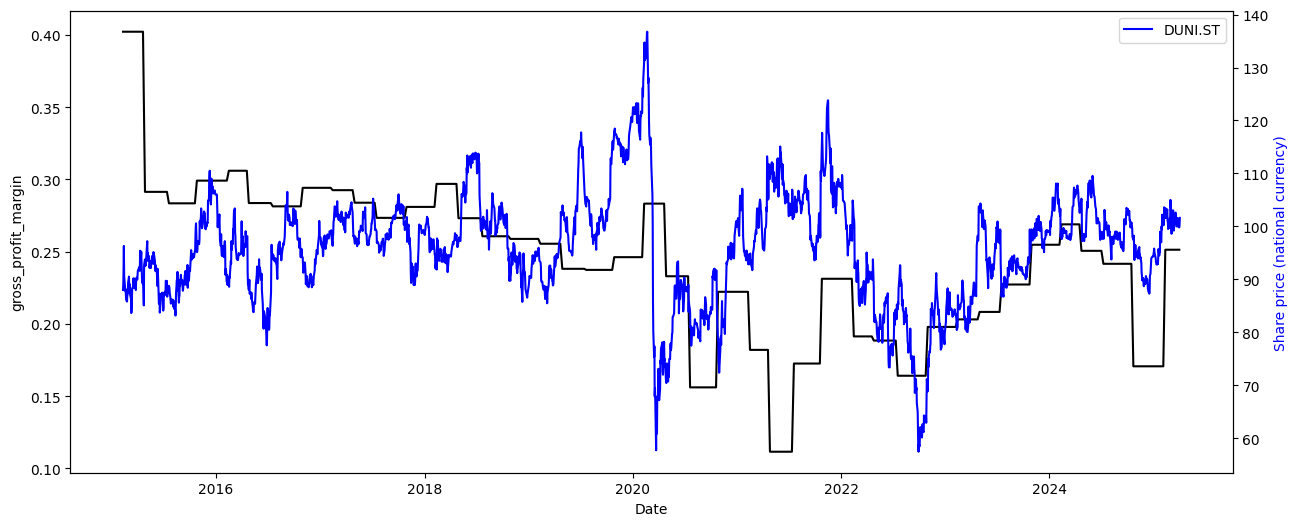

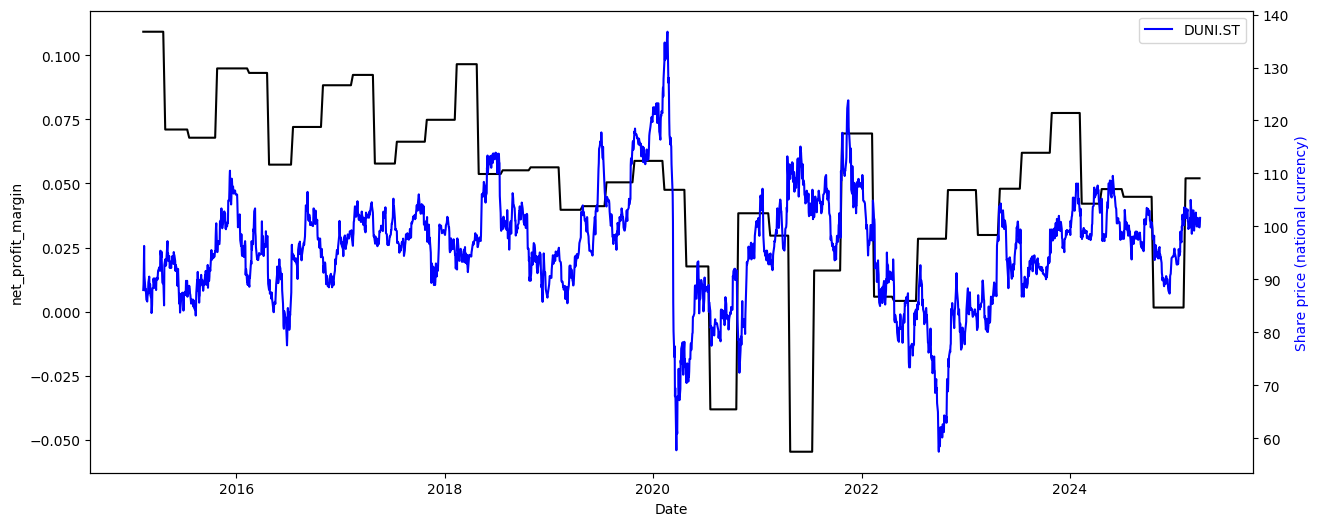

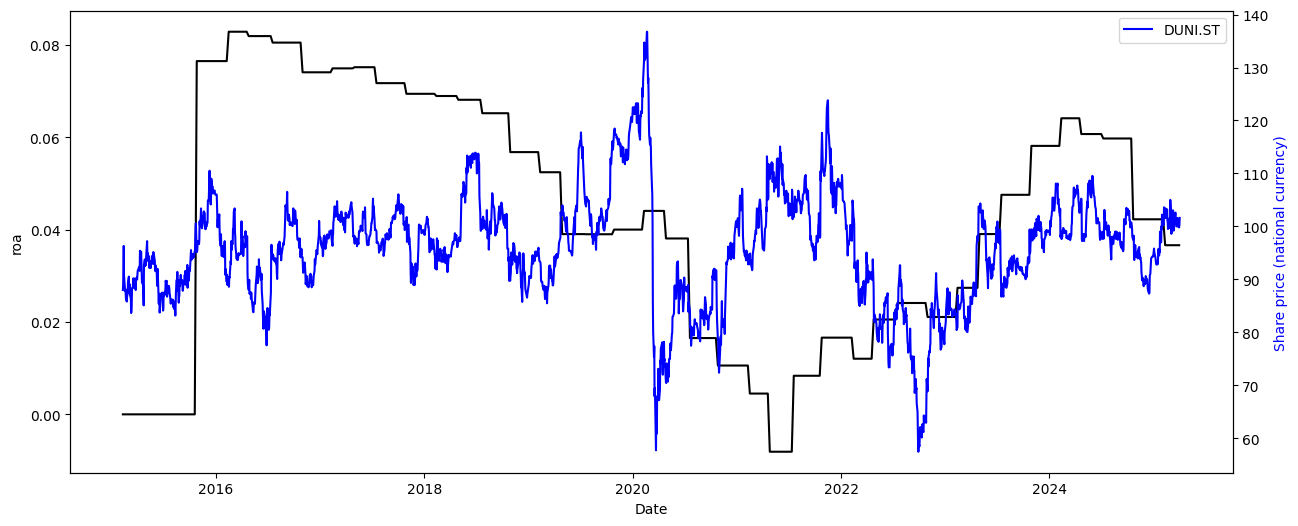

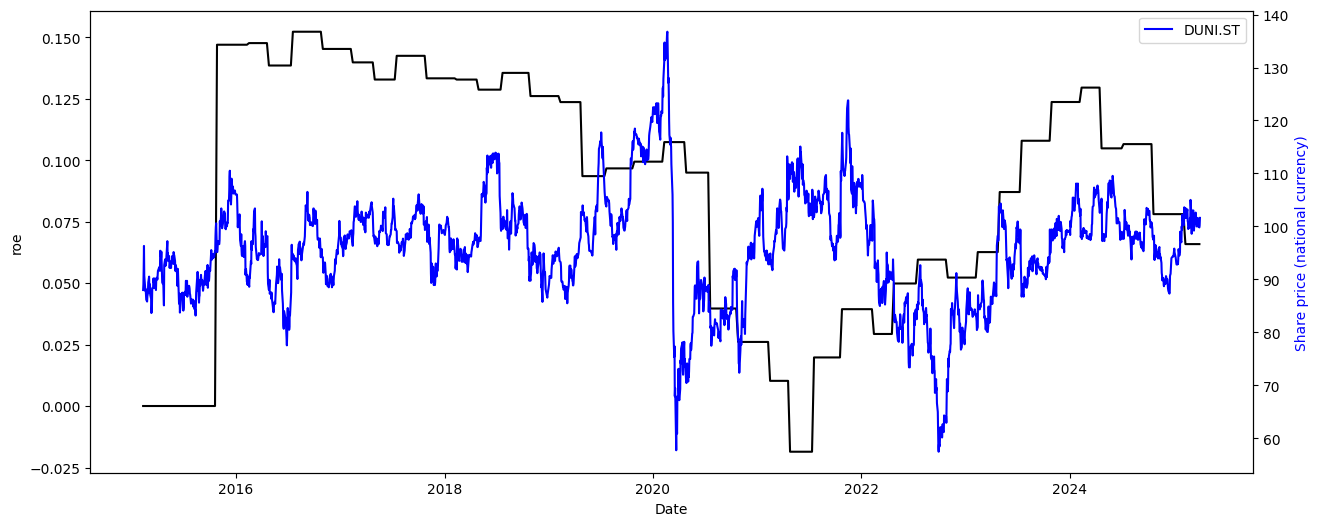

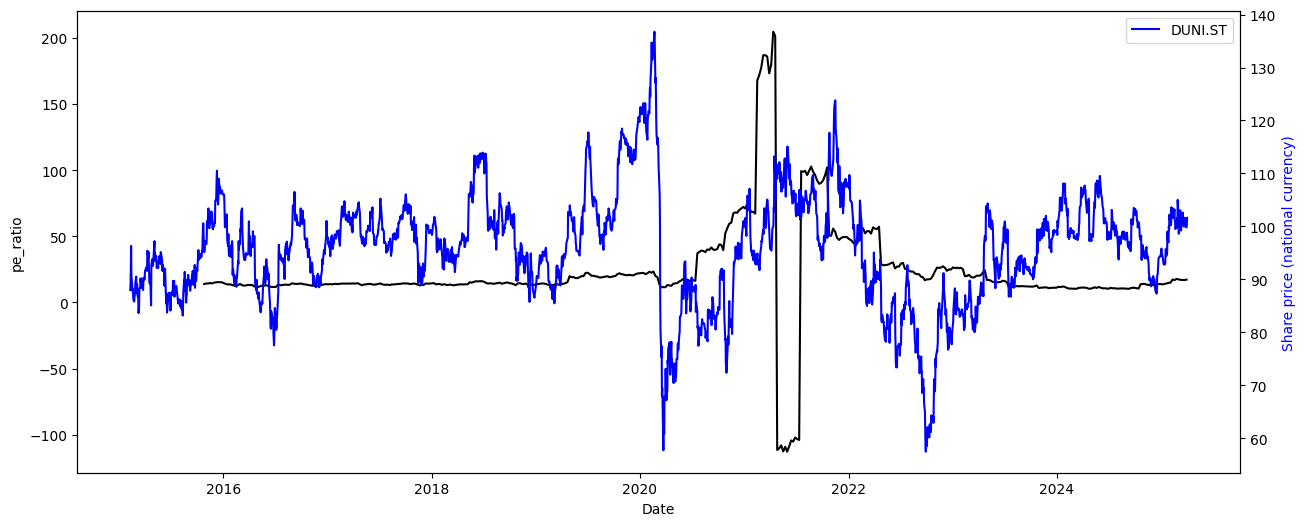

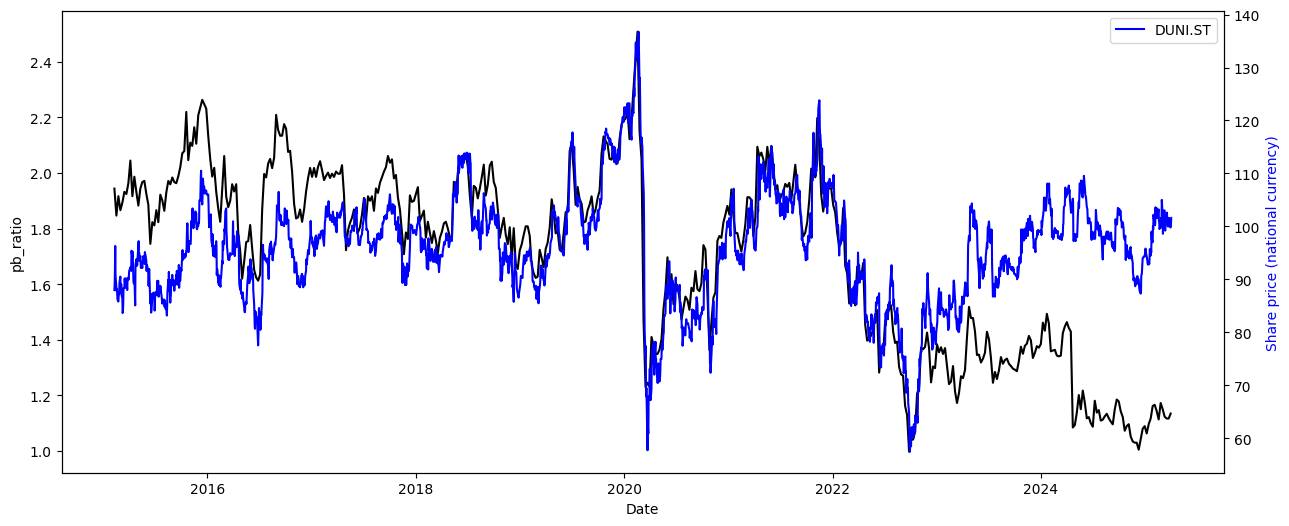

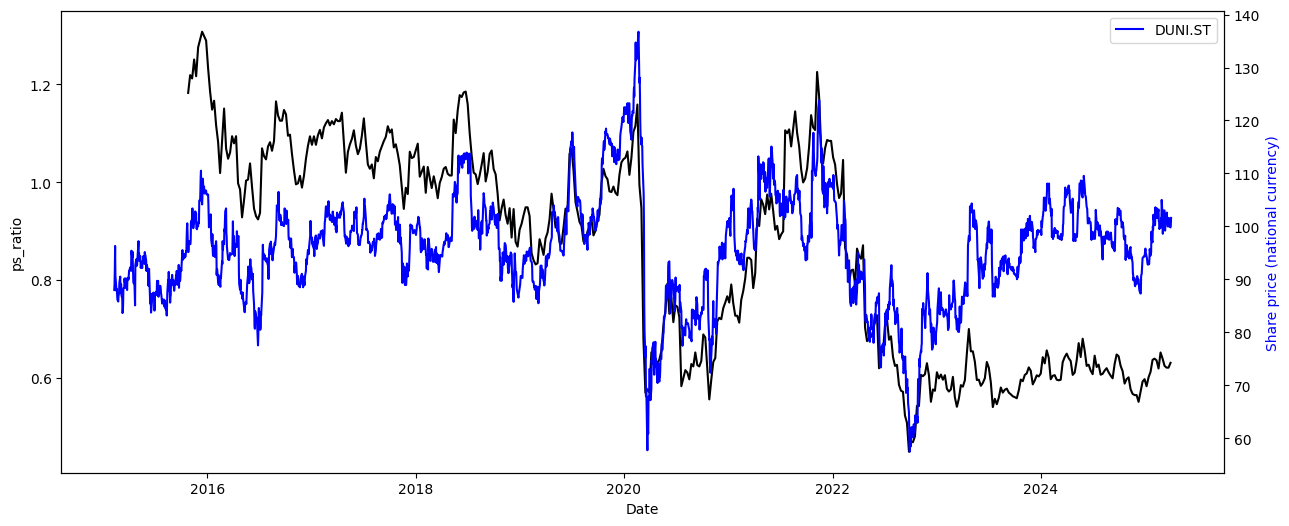

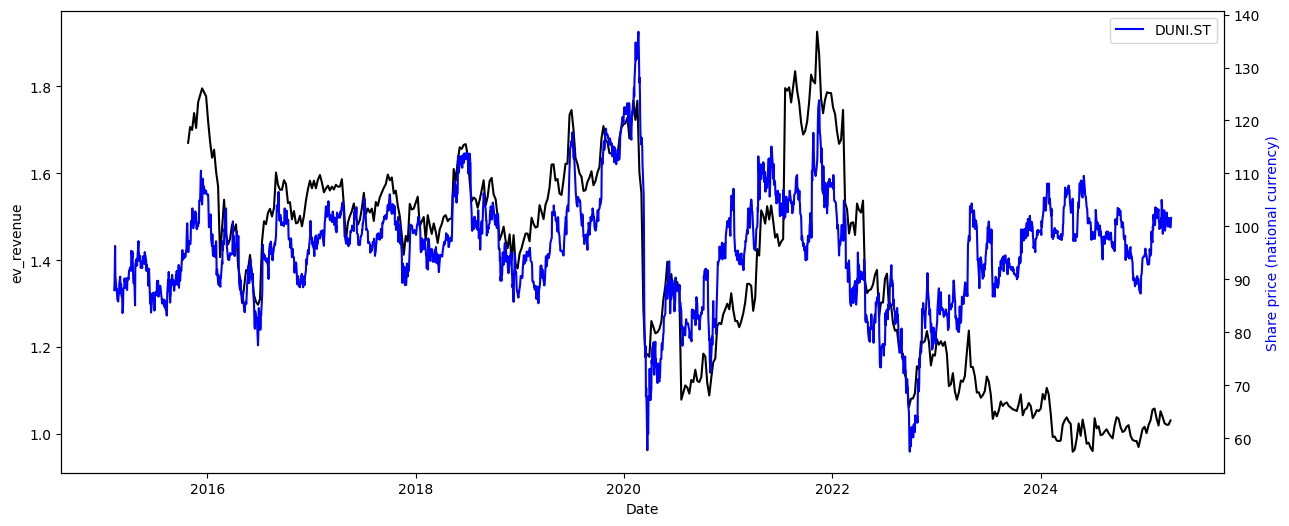

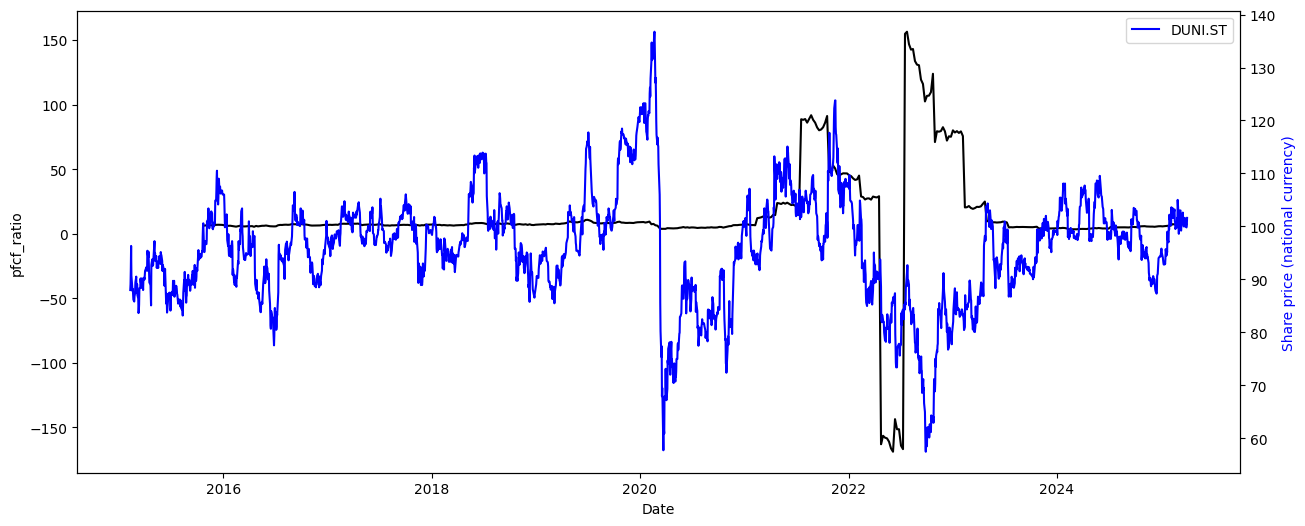

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

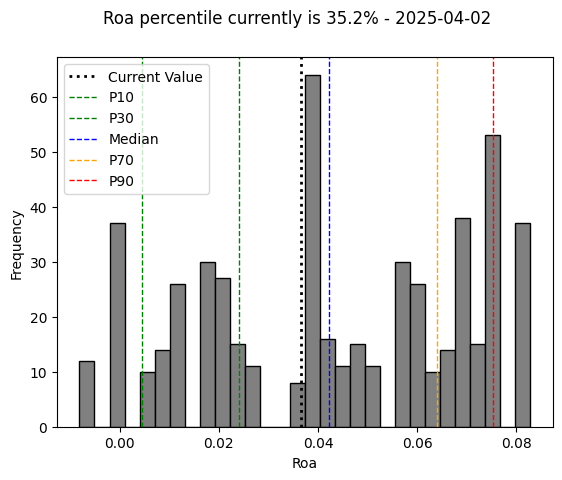

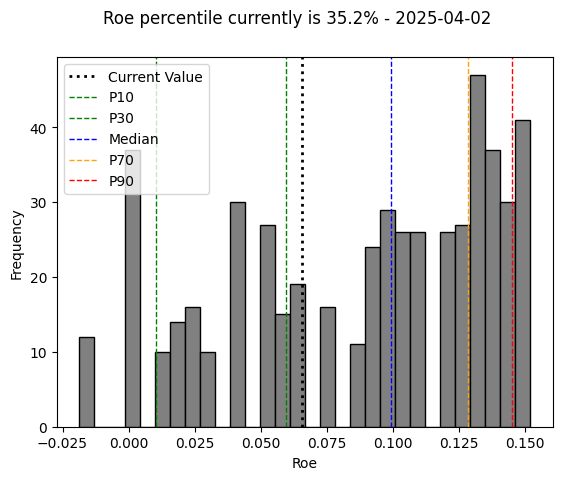

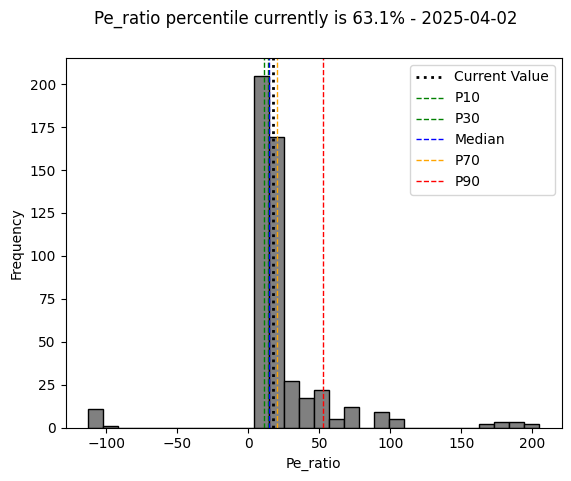

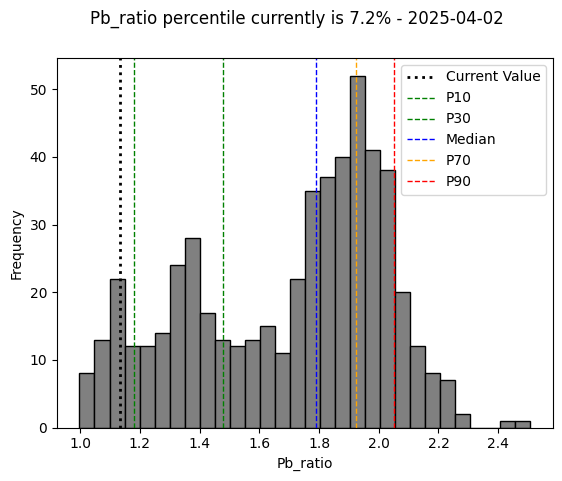

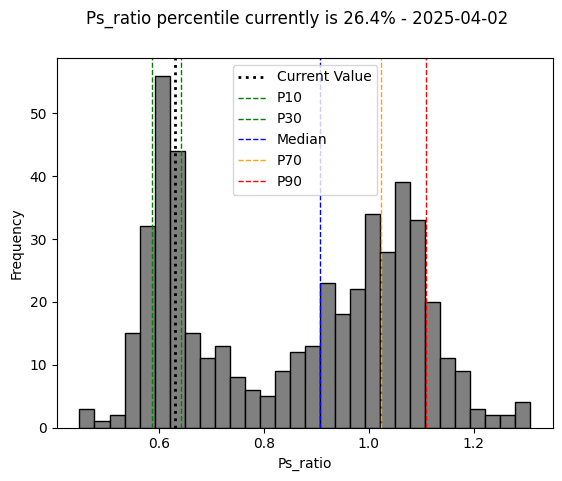

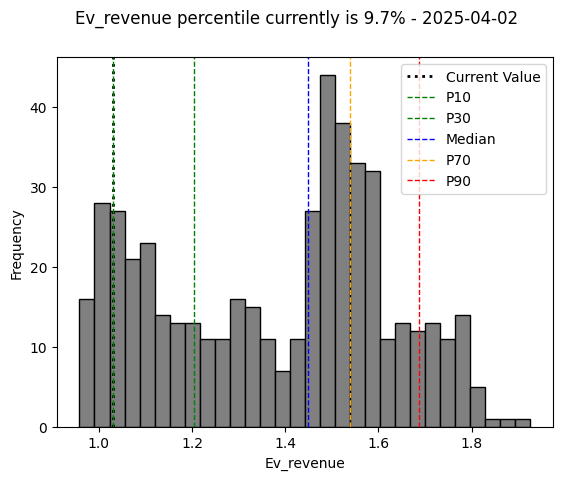

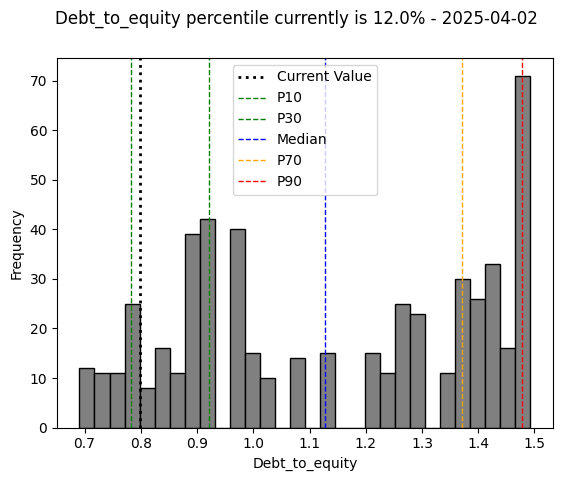

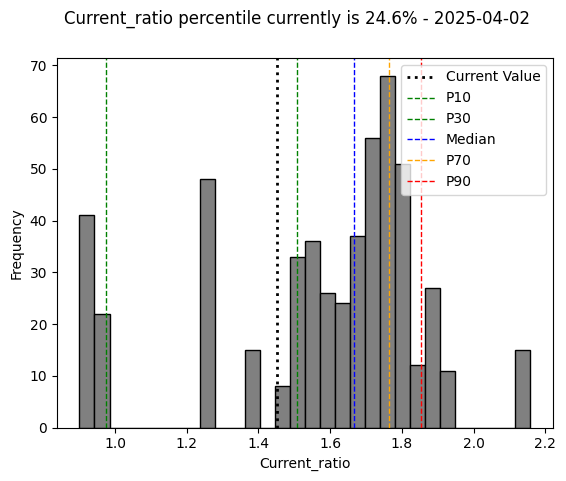

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.980122,-0.289104,0.081258,0.406991,0.105544,-0.579017,0.215258
roe,0.980122,1.000000,-0.288336,0.080937,0.379345,0.133974,-0.428744,0.263051
pe_ratio,-0.289104,-0.288336,1.000000,0.050763,-0.006508,0.083211,0.238140,-0.244829
pb_ratio,0.081258,0.080937,0.050763,1.000000,0.914473,0.901445,-0.023020,0.058824
ps_ratio,0.406991,0.379345,-0.006508,0.914473,1.000000,0.914042,-0.273210,0.062546
ev_revenue,0.105544,0.133974,0.083211,0.901445,0.914042,1.000000,0.110429,0.064458
debt_to_equity,-0.579017,-0.428744,0.238140,-0.023020,-0.273210,0.110429,1.000000,0.131577
current_ratio,0.215258,0.263051,-0.244829,0.058824,0.062546,0.064458,0.131577,1.000000


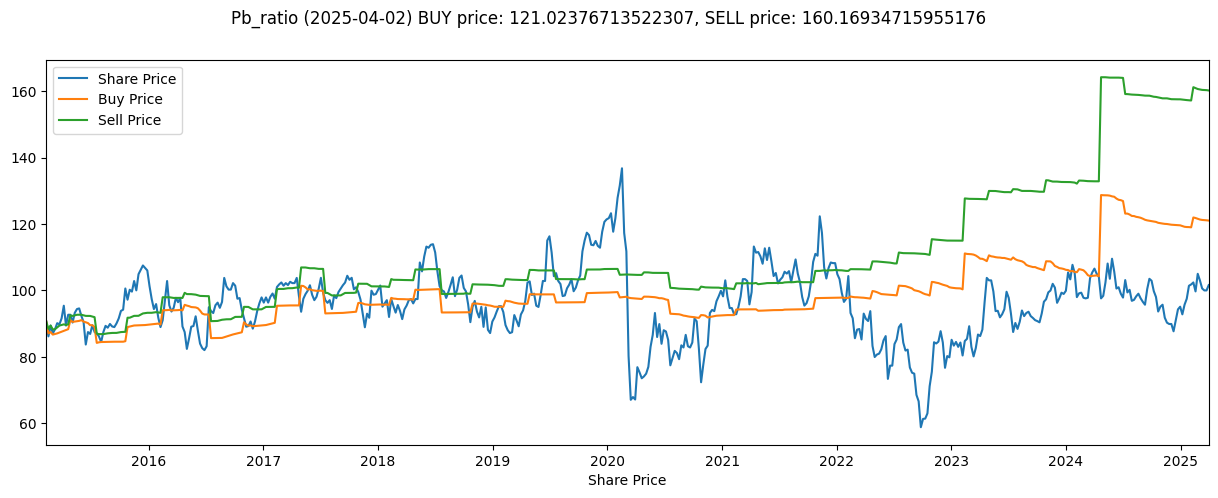

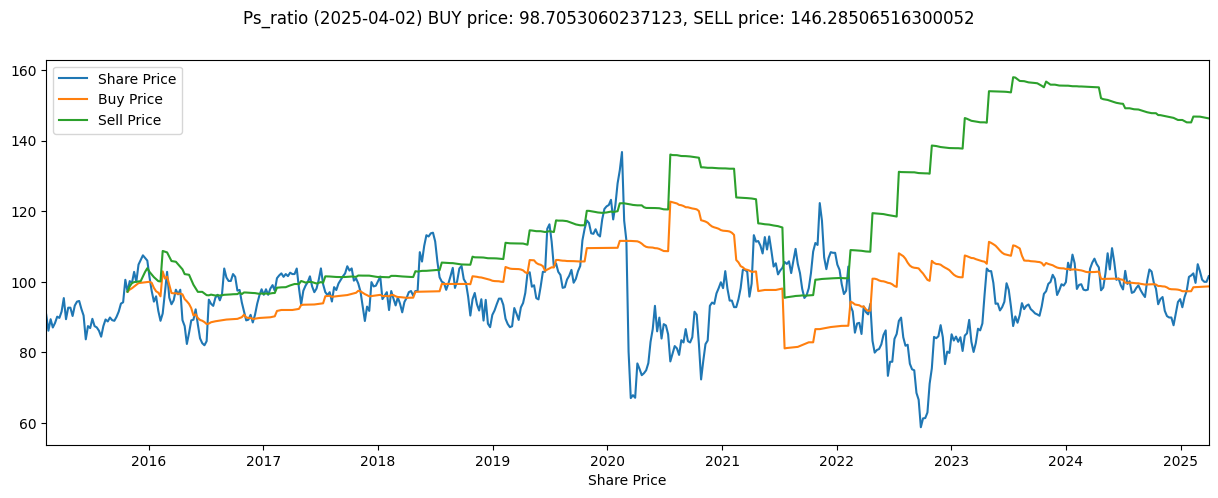

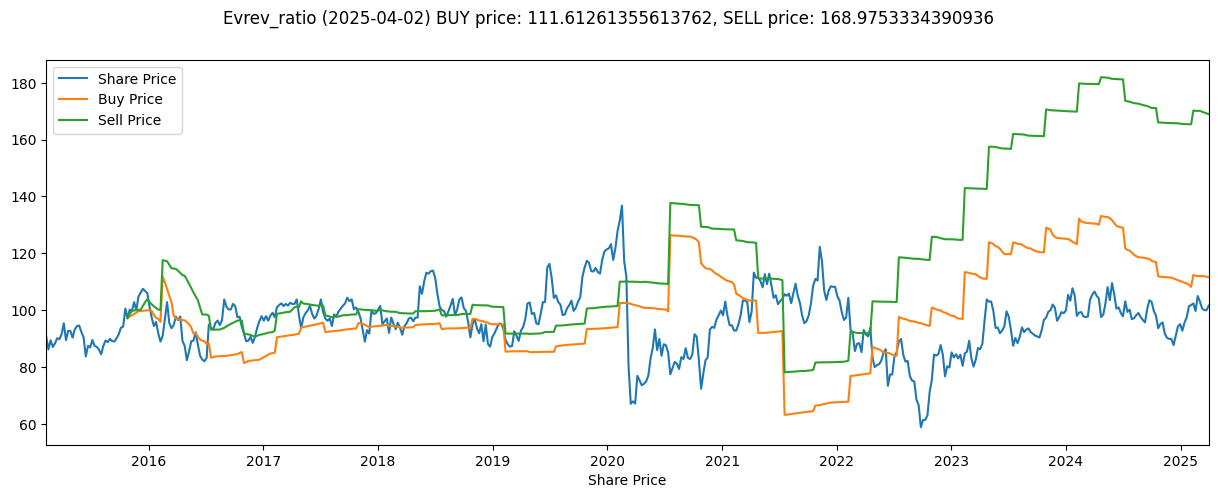

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)